In [9]:
!pip install -q git+https://github.com/DataScienceUWL/DS776.git#subdirectory=introdl

# Segmentation using UNET

In [1]:
import json
from pathlib import Path

# Load JSON config file
with open("../config.json", "r") as f:
    config = json.load(f)

# Convert paths to Path objects using pathlib
MODELS_PATH = Path(config["MODELS_PATH"])
DATA_PATH = Path(config["DATA_PATH"])
TORCH_HOME = Path(config["TORCH_HOME"])

import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from dotenv import load_dotenv
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp

from introdl.idlmam import train_network
from introdl.utils import get_device, load_model

# Using Segmentation Models Pytorch Package

In [2]:
from pathlib import Path
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
from sklearn.model_selection import train_test_split
import torchvision.transforms.v2 as T

class PennFudanSegment(Dataset):
    def __init__(self, root, transforms=None, split='train', seed=42):
        self.root = Path(root)
        self.transforms = transforms

        # Load all image and mask files
        all_imgs = sorted((self.root / "PNGImages").iterdir())
        all_masks = sorted((self.root / "PedMasks").iterdir())

        # Split the indices into train and validation sets
        indices = list(range(len(all_imgs)))
        train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

        # Select the appropriate indices based on the split
        if split == 'train':
            selected_indices = train_indices
        elif split == 'val':
            selected_indices = val_indices
        else:
            raise ValueError("Split must be 'train' or 'val'")

        # Filter images and create combined masks for selected indices
        self.imgs = [all_imgs[i] for i in selected_indices]
        self.masks = []
        for i in selected_indices:
            mask = read_image(str(all_masks[i]))
            combined_mask = (mask > 0).to(dtype=torch.float32)  # Combine all instance masks into one binary mask with float values
            self.masks.append(tv_tensors.Mask(combined_mask))  # Convert mask to tv_tensor type

    def __getitem__(self, idx):
        # Load image
        img_path = self.imgs[idx]
        img = read_image(str(img_path)).float() / 255.0  # Ensure float type and normalize to [0, 1]

        # Load precomputed combined mask
        combined_mask = self.masks[idx]

        # Convert image to tv_tensor type
        img = tv_tensors.Image(img)

        # Apply transformations
        if self.transforms is not None:
            img, combined_mask = self.transforms(img, combined_mask)

        return img, combined_mask

    def __len__(self):
        return len(self.imgs)


In [17]:
# Define training transformations
train_transforms = T.Compose([
    T.Resize((224, 224)),  # Resize to 224x224
    T.RandomHorizontalFlip(0.5),  # Random horizontal flip with 50% probability
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color jitter
    T.RandomRotation(degrees=(-10, 10)),  # Random rotation within +/- 10 degrees
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Define validation transformations (no data augmentation, just tensor conversion)
val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Usage with the dataset
dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
train_dataset = PennFudanSegment(root=dataset_path, transforms=train_transforms, split='train')
val_dataset = PennFudanSegment(root=dataset_path, transforms=val_transforms, split='val')

# Define training and validation data loaders
train_loader = DataLoader(train_dataset,batch_size=8,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=8,shuffle=False)

In [18]:
def overlay_masks(image, mask, color, thickness=1):
    """
    Overlay a binary mask outline on an image.

    Parameters:
    - image (numpy.ndarray): The image on which to overlay the mask.
    - mask (numpy.ndarray): The binary mask (1 for mask, 0 for background).
    - color (tuple): The color for the mask outline in (B, G, R) format.

    Returns:
    - image (numpy.ndarray): The image with the mask outline overlaid.
    """
    mask = (mask > 0.5).astype(np.uint8)
    if len(mask.shape) > 2:
        mask = mask.squeeze()  # Ensure single-channel mask

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, color, thickness)
    return image

def denormalize_image(image, mean, std):
    """Reverse normalization for visualization."""
    mean = np.array(mean)
    std = np.array(std)
    return (image * std + mean).clip(0, 1)

def display_images_and_masks(dataset, num_samples=3, model=None, indices=None, figsize=(4, 4), overlay=True, 
                             denormalize=True, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Display random samples from the dataset with ground truth masks. If a model is provided, it also displays predicted masks.

    Parameters:
    - dataset: The dataset containing the images and ground truth masks.
    - num_samples: The number of random samples to display (default: 3).
    - model: The segmentation model. If None, only ground truth masks are displayed.
    - indices (list, optional): The indices of the samples to display. If None, random samples will be selected.
    - figsize (tuple, optional): The size of the display figure (default: (6, 6)).
    - overlay (bool, optional): If True, overlays the mask on the image. If False, displays image and mask side-by-side.
    - denormalize (bool, optional): If True, denormalizes the images before displaying (default: False).
    """
    if indices is None:
        indices = random.sample(range(len(dataset)), num_samples)
    
    device = None
    if model is not None:
        model.eval()
        device = next(model.parameters()).device

    for idx in indices:
        # Load the image and ground truth mask
        image, target_mask = dataset[idx]
        
        # Move image to device for model prediction
        pred_mask = None
        if model is not None:
            image_for_model = image.to(device)
            with torch.no_grad():
                logits = model(image_for_model.unsqueeze(0))[0].squeeze().cpu()
                pred_mask = torch.sigmoid(logits.clone().detach()).numpy()

        # Convert image to numpy and optionally denormalize
        img_np = image.permute(1, 2, 0).cpu().numpy() if device else image.permute(1, 2, 0).numpy()
        if denormalize:
            img_np = denormalize_image(img_np, mean, std)
        img_np = (img_np * 255).astype(np.uint8)  # Scale for OpenCV display

        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        gt_mask = target_mask.cpu().numpy() if device else target_mask.numpy()

        if overlay:
            # Overlay ground truth mask in blue
            img_overlay = overlay_masks(img_bgr.copy(), gt_mask, color=(255, 0, 0))
            
            # Overlay predicted mask in orange if model is provided
            if pred_mask is not None:
                pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize predicted mask
                img_overlay = overlay_masks(img_overlay, pred_mask, color=(0, 165, 255))

            img_rgb_overlay = cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=figsize)
            plt.imshow(img_rgb_overlay)
            plt.axis('off')
            plt.show()

        else:
            # Prepare separate images for side-by-side display
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            mask_rgb = (gt_mask.squeeze() * 255).astype(np.uint8)
            mask_rgb = np.stack([mask_rgb] * 3, axis=-1)  # Convert to 3-channel grayscale
            
            images = [img_rgb, mask_rgb]
            titles = ['Image', 'Ground Truth Mask']
            
            # Add predicted mask if model is provided
            if pred_mask is not None:
                pred_rgb = (pred_mask * 255).astype(np.uint8)  # Display as binary mask in grayscale
                pred_rgb = np.stack([pred_rgb] * 3, axis=-1)  # Convert to 3-channel grayscale
                images.append(pred_rgb)
                titles.append('Predicted Mask')
            
            plt.figure(figsize=(figsize[0] * len(images), figsize[1]))
            for i, (title, img) in enumerate(zip(titles, images)):
                plt.subplot(1, len(images), i + 1)
                plt.imshow(img)
                plt.title(title)
                plt.axis('off')
            plt.show()


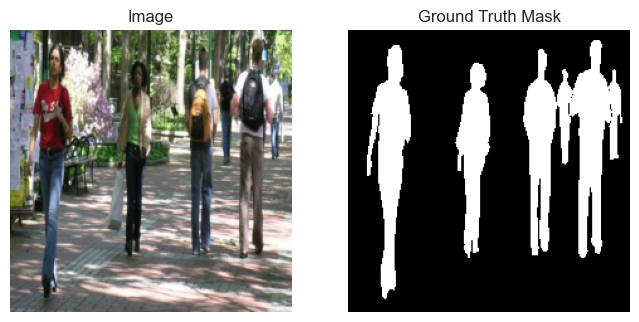

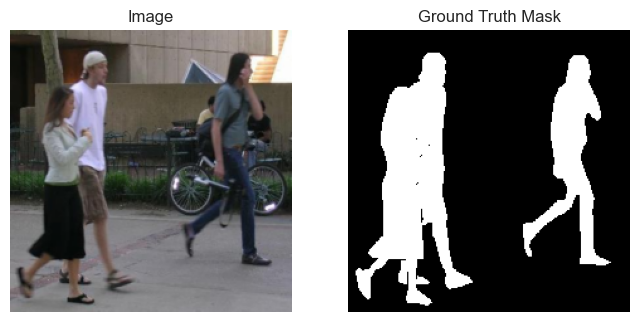

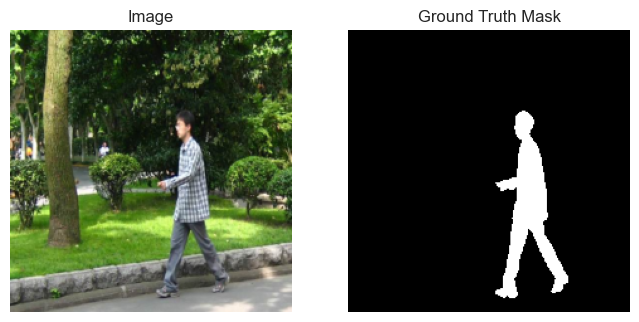

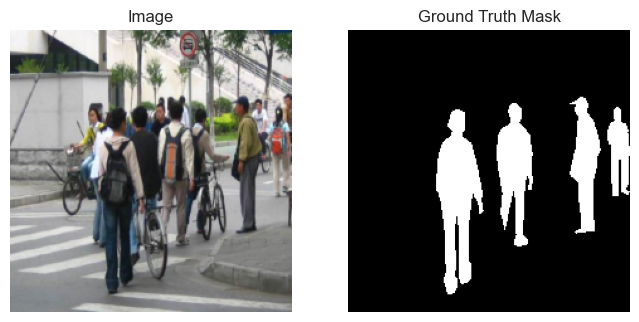

In [19]:
selected_images = [4,0,1,13]
display_images_and_masks(val_dataset, overlay=False, indices=selected_images, denormalize=True)

In binary segmentation, **Intersection over Union (IoU)** is a metric used to measure the overlap between the predicted segmentation mask and the ground truth mask. IoU, also called the **Jaccard Index**, evaluates how well the predicted mask matches the actual object or region of interest in the image.

### How IoU Works in Binary Segmentation
1. **Binary Masks**: In binary segmentation, each pixel in the image is classified as either foreground (1) or background (0). The ground truth mask contains the actual segmentation (e.g., the region of interest), while the predicted mask is the model’s output, showing where it believes the foreground is located.

2. **Intersection and Union**:
   - **Intersection**: The number of pixels where the predicted mask and the ground truth mask both indicate foreground (1).
   - **Union**: The total number of pixels where either the predicted mask or the ground truth mask indicates foreground (1). This includes the intersection area and any areas marked as foreground in either mask.

3. **Formula**:
   $$\text{IoU} = \frac{\text{Intersection}}{\text{Union}} = \frac{|A \cap B|}{|A \cup B|}$$
   
   where:
   - $A$ is the set of pixels in the ground truth mask labeled as foreground.
   - $B$ is the set of pixels in the predicted mask labeled as foreground.

### Example Calculation
Suppose we have the following results for a single binary mask:
- **True Positives (TP)**: Pixels correctly predicted as foreground.
- **False Positives (FP)**: Pixels incorrectly predicted as foreground (should be background).
- **False Negatives (FN)**: Pixels incorrectly predicted as background (should be foreground).

Using these values, IoU can be calculated as:
$$\text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$

### Interpretation of IoU Values
- **IoU = 1**: Perfect segmentation; the predicted mask exactly matches the ground truth mask.
- **IoU = 0**: No overlap; the predicted mask does not overlap with the ground truth mask at all.
- **0 < IoU < 1**: Partial overlap; higher IoU values indicate better segmentation accuracy.

### IoU in Practice
- **Threshold for Good Segmentation**: Typically, an IoU of 0.5 or above is considered acceptable in many applications, though stricter thresholds (e.g., 0.75) are used in cases requiring high precision.
- **Challenges**: Small or thin objects may lead to lower IoU scores, as even minor misalignment can significantly impact the intersection area.

### Comparison to Dice Coefficient
IoU is closely related to the **Dice Coefficient**, which is another popular metric in segmentation:
$$\text{Dice} = \frac{2 \times \text{Intersection}}{\text{Total Pixels in Predicted Mask + Ground Truth Mask}} = \frac{2 \times |A \cap B|}{|A| + |B|}$$
While IoU emphasizes the union, Dice places more weight on the intersection area, making it slightly more forgiving for small misalignments. Both metrics are valuable for assessing segmentation accuracy, with IoU focusing on exact overlap and Dice balancing precision and recall.

In [20]:
backbone="resnet34"
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan.pth"

# Set up the U-Net model
model = smp.Unet(
    encoder_name=backbone,       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

device = get_device()

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation
optimizer = optim.AdamW(model.parameters(), lr=0.001)

score_funcs = {"IOU": jaccard_score}

num_epochs = 10
results = train_network(model, 
                        loss_fn,
                        train_loader, 
                        optimizer=optimizer,
                        val_loader=val_loader, 
                        device=device, 
                        checkpoint_file=checkpoint_file,
                        epochs=num_epochs,
                        early_stop_metric="IOU",
                        early_stop_crit="max",
                        patience=2,
                        score_funcs=score_funcs)

Epoch: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


In [21]:
results

,epoch,total time,train loss,val loss,train IOU,val IOU
0,0,2.395544,0.357765,0.433503,0.336780,0.478669
1,1,4.869093,0.224812,0.256740,0.545729,0.585147
2,2,7.497477,0.175028,0.250054,0.626483,0.590425
3,3,10.103121,0.168221,0.196710,0.632597,0.636681
4,4,12.671923,0.149300,0.136294,0.655107,0.651788
5,5,15.260220,0.141045,0.133154,0.693470,0.693613
6,6,17.805238,0.129787,0.132196,0.716108,0.702066
7,7,20.413952,0.116214,0.112192,0.734173,0.718664
8,8,22.842443,0.111036,0.129192,0.761271,0.722582
9,9,25.682481,0.104553,0.127459,0.771595,0.608736


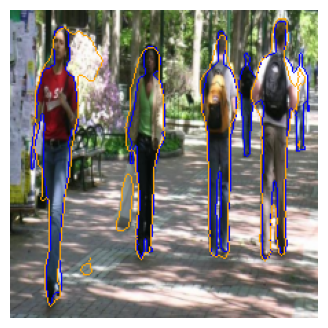

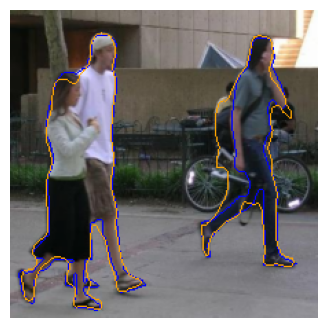

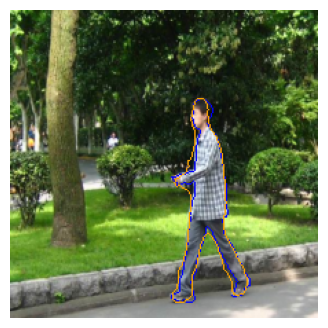

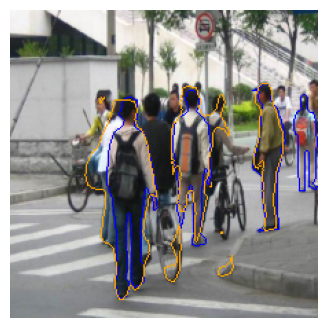

In [22]:
backbone="resnet34"
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan.pth"

model = smp.Unet(
    encoder_name=backbone,       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True)

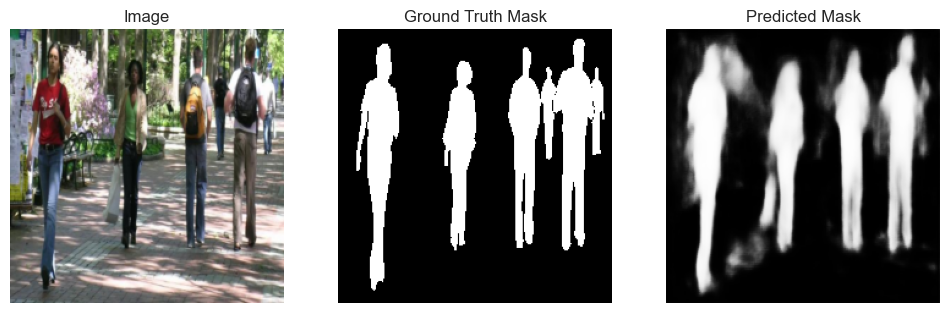

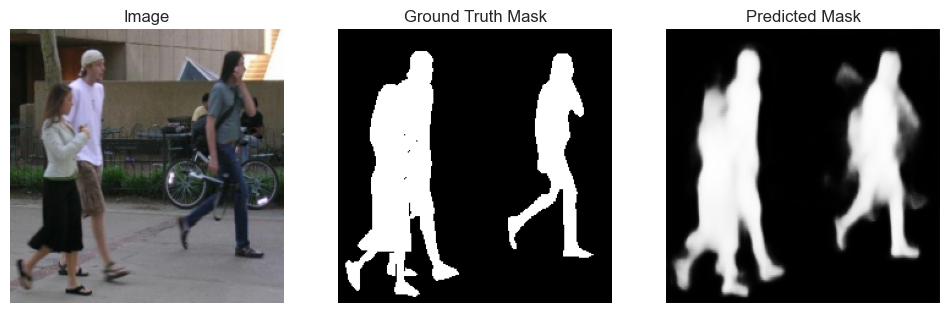

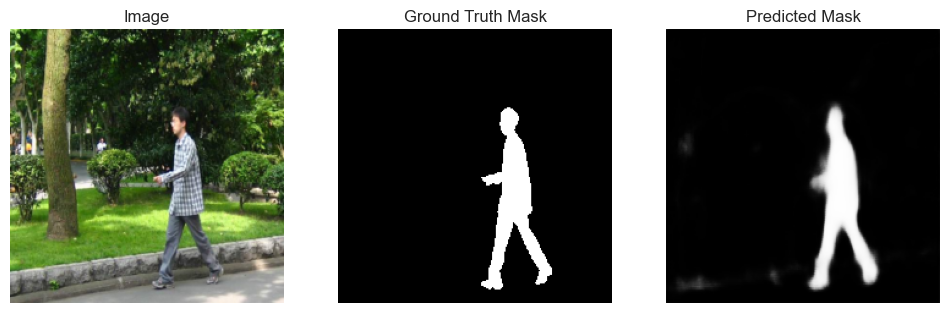

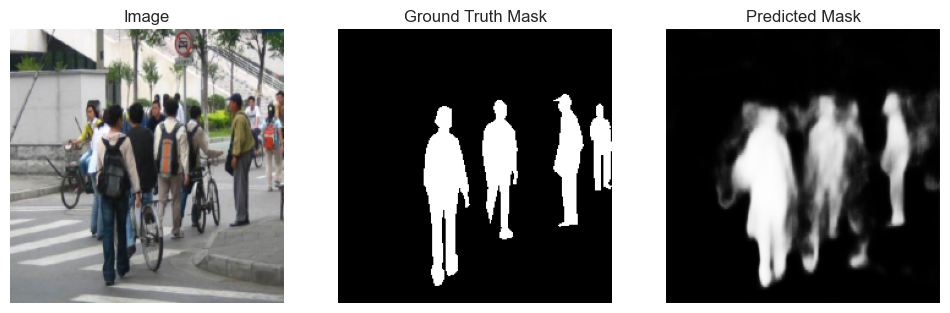

In [23]:
display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=False)